In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

In [2]:
PARAMETERS.LBP_METHOD = 'riu2'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 1
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = False
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu2,get_pyramid_dataset,lanczos,False,1,True,False


In [3]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for r in range(2, 5):
    db_path = f'../DB/{PARAMETERS.DATASET}/extra_features/radius/{r}'
    for filename in Path(db_path).glob('train_train_*'):   
        file_extension = \
            str(filename).replace('train_train_', '').split('/')[-1].replace('.pkl', '')
        properties = file_extension.replace(
            'get_pyramid_dataset', 'get-pyramid-dataset').replace(
            'get_datasets_by_scale', 'get-dataset-by-scale').split('_')
        lbp_method = properties[0]
        df_train_temp = pd.read_pickle(filename, compression='gzip')
        df_test_temp = pd.read_pickle(str(filename).replace('train_train', 'train_test'), compression='gzip')
        df_train_temp = df_train_temp.drop(['Original', 'label'], axis=1)
        df_test_temp = df_test_temp.drop(['Original', 'label'], axis=1)
        df_train_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_test_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_train = pd.concat([df_train, df_train_temp], axis=1)
        df_test = pd.concat([df_test, df_test_temp], axis=1)

In [4]:
df_train

,1:1_var_2,1:1_nriuniform_2,1:1_default_2,1:1_riu2_2,1:1_var_3,1:1_nriuniform_3,1:1_default_3,1:1_riu2_3,1:1_var_4,1:1_nriuniform_4,1:1_default_4,1:1_riu2_4
0,46,120,1,8,181,20,1,12,170,240,1,16
1,150,120,1,8,197,20,1,12,48,240,1,16
2,253,120,1,8,93,20,1,12,6,240,1,16
3,62,120,1,8,35,20,1,12,162,240,1,16
4,66,120,1,8,56,252,0,11,131,208,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
226537,214,128,254,8,248,32,254,12,245,0,254,16
226538,218,128,254,8,20,32,254,12,231,0,254,16
226539,255,128,254,8,41,32,254,12,208,0,254,16
226540,9,128,254,8,93,32,254,12,179,0,254,16


In [5]:
PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

def get_convolution_features(seed=0):
    #np.random.seed(seed)
    #kernel_list = [np.round(np.random.uniform(low=-1, high=1, size=(9,)).reshape(3, 3), 3) for _ in range(5)]
    #kernel_list += [np.round(np.random.uniform(low=-1, high=1, size=(25,)).reshape(5, 5), 3) for _ in range(5)]

    kernel_list = []
    # https://dsp.stackexchange.com/questions/44928/what-does-derivative-means-in-image-processing/44930
    # LAPLACIAN
    kernel_list.append(np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]))
    kernel_list.append(np.array([[-1, 2, -1], [2, -8, 2], [-1, 2, -1]]))

    # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d
    # SCHARR
    kernel_list.append(np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]))
    kernel_list.append(np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]))

    # https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
    # SOBEL
    kernel_list.append(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    kernel_list.append(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))

    paths = []
    for kernel in kernel_list:
        PARAMETERS.CONVOLUTION = kernel
        PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
        paths.append(f"../DB/{PARAMETERS.DATASET}/extra_features/convolution/{PARAMETERS.CONV_PATH}")


    for i, path in enumerate(paths):
        train_path = list(Path(path).glob('train_train*'))[0]
        test_path = list(Path(path).glob('train_test*'))[0]
        if i == 0:
            df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
            df_train_convolutions.drop(['label'], axis=1, inplace=True)
            df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
            df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
            df_test_convolutions.drop(['label'], axis=1, inplace=True)
            df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
        else:
            df_temp = pd.read_pickle(train_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
            df_temp = pd.read_pickle(test_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)
    return df_train_convolutions, df_test_convolutions

df_train_convolutions, df_test_convolutions = get_convolution_features(seed=0)
#df_train_convolutions0, df_test_convolutions0 = get_convolution_features(seed=0)
#df_train_convolutions1, df_test_convolutions1 = get_convolution_features(seed=1)
#df_train_convolutions2, df_test_convolutions2 = get_convolution_features(seed=2)

#df_train_convolutions = pd.concat([df_train_convolutions0, df_train_convolutions1, df_train_convolutions2], axis=1)
#df_test_convolutions = pd.concat([df_test_convolutions0, df_test_convolutions1, df_test_convolutions2], axis=1)

In [6]:
df_train_convolutions

,Original_0;1;0;1;-4;1;0;1;0,1:1_0;1;0;1;-4;1;0;1;0,1:2_0;1;0;1;-4;1;0;1;0,1:4_0;1;0;1;-4;1;0;1;0,1:8_0;1;0;1;-4;1;0;1;0,2:1_1_0;1;0;1;-4;1;0;1;0,2:1_2_0;1;0;1;-4;1;0;1;0,2:1_3_0;1;0;1;-4;1;0;1;0,2:1_4_0;1;0;1;-4;1;0;1;0,Original_-1;2;-1;2;-8;2;-1;2;-1,...,2:1_4_-1;0;1;-2;0;2;-1;0;1,Original_-1;-2;-1;0;0;0;1;2;1,1:1_-1;-2;-1;0;0;0;1;2;1,1:2_-1;-2;-1;0;0;0;1;2;1,1:4_-1;-2;-1;0;0;0;1;2;1,1:8_-1;-2;-1;0;0;0;1;2;1,2:1_1_-1;-2;-1;0;0;0;1;2;1,2:1_2_-1;-2;-1;0;0;0;1;2;1,2:1_3_-1;-2;-1;0;0;0;1;2;1,2:1_4_-1;-2;-1;0;0;0;1;2;1
0,1.0,240.0,16.0,255.0,255.0,255.0,255.0,240.0,241.0,0.0,...,56.0,-0.0,207.0,241.0,255.0,255.0,3.0,193.0,255.0,1.0
1,1.0,243.0,16.0,255.0,255.0,255.0,238.0,225.0,64.0,0.0,...,227.0,-0.0,255.0,241.0,255.0,255.0,96.0,17.0,0.0,255.0
2,1.0,225.0,16.0,255.0,255.0,255.0,255.0,241.0,225.0,0.0,...,241.0,-0.0,255.0,241.0,255.0,255.0,1.0,0.0,239.0,239.0
3,1.0,224.0,16.0,255.0,255.0,255.0,238.0,240.0,241.0,0.0,...,112.0,-0.0,255.0,241.0,255.0,255.0,255.0,239.0,233.0,225.0
4,1.0,254.0,18.0,255.0,255.0,255.0,238.0,224.0,241.0,0.0,...,255.0,-0.0,255.0,241.0,255.0,255.0,239.0,238.0,225.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,1.0,225.0,1.0,0.0,225.0,193.0,225.0,224.0,243.0,0.0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226538,1.0,96.0,1.0,0.0,225.0,193.0,0.0,102.0,254.0,0.0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226539,1.0,241.0,1.0,16.0,225.0,49.0,16.0,254.0,255.0,0.0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226540,1.0,129.0,1.0,16.0,225.0,209.0,241.0,96.0,255.0,0.0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [7]:
df_train = pd.concat([df_train, df_train_convolutions], axis=1)
df_test = pd.concat([df_test, df_test_convolutions], axis=1)

In [8]:
df_train

,1:1_var_2,1:1_nriuniform_2,1:1_default_2,1:1_riu2_2,1:1_var_3,1:1_nriuniform_3,1:1_default_3,1:1_riu2_3,1:1_var_4,1:1_nriuniform_4,...,2:1_4_-1;0;1;-2;0;2;-1;0;1,Original_-1;-2;-1;0;0;0;1;2;1,1:1_-1;-2;-1;0;0;0;1;2;1,1:2_-1;-2;-1;0;0;0;1;2;1,1:4_-1;-2;-1;0;0;0;1;2;1,1:8_-1;-2;-1;0;0;0;1;2;1,2:1_1_-1;-2;-1;0;0;0;1;2;1,2:1_2_-1;-2;-1;0;0;0;1;2;1,2:1_3_-1;-2;-1;0;0;0;1;2;1,2:1_4_-1;-2;-1;0;0;0;1;2;1
0,46,120,1,8,181,20,1,12,170,240,...,56.0,-0.0,207.0,241.0,255.0,255.0,3.0,193.0,255.0,1.0
1,150,120,1,8,197,20,1,12,48,240,...,227.0,-0.0,255.0,241.0,255.0,255.0,96.0,17.0,0.0,255.0
2,253,120,1,8,93,20,1,12,6,240,...,241.0,-0.0,255.0,241.0,255.0,255.0,1.0,0.0,239.0,239.0
3,62,120,1,8,35,20,1,12,162,240,...,112.0,-0.0,255.0,241.0,255.0,255.0,255.0,239.0,233.0,225.0
4,66,120,1,8,56,252,0,11,131,208,...,255.0,-0.0,255.0,241.0,255.0,255.0,239.0,238.0,225.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,214,128,254,8,248,32,254,12,245,0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226538,218,128,254,8,20,32,254,12,231,0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226539,255,128,254,8,41,32,254,12,208,0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226540,9,128,254,8,93,32,254,12,179,0,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.324370 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.461180 seconds.
You can set `force_col_wise=true` to remove the overhead.


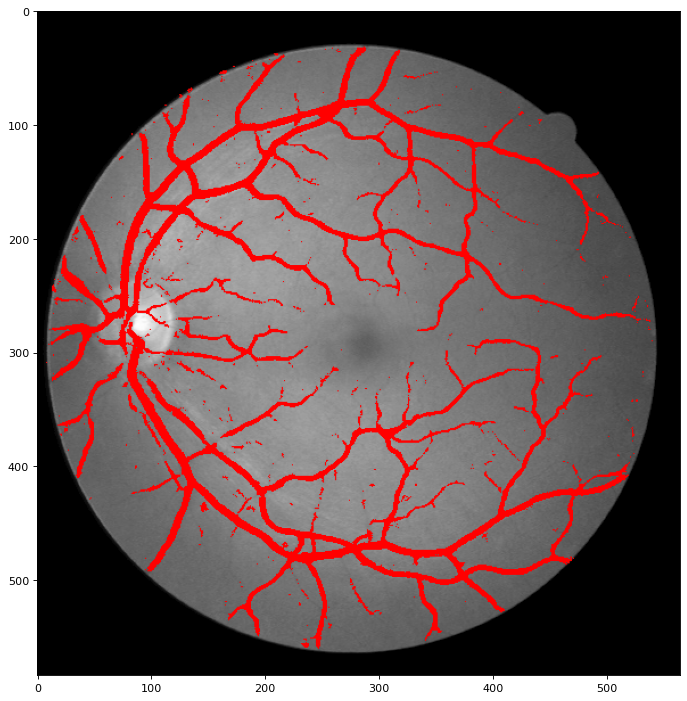

Accuracy score: 0.9413696414563072

F1 score: 0.7729775807689029

Confusion matrix:

     t/p      0     1 
        0 1146794 40751 
        1 39145 136017 
Sensivity: 0.7765211632660052
Specificity: 0.9656846687914984


(0.941, 0.773, 1146794, 40751, 39145, 136017)

In [9]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=True, plot_once=True, extra_features={'train': df_train, 'test': df_test}, add_channels=True, recurrence=True)

In [10]:
with open(f"../models/lbm_fit_optimal.pkl", 'rb') as f:
    model = pickle.load(f)

In [11]:
feature_imp = pd.DataFrame(sorted(zip(model['clf'].feature_importances_, model['features'])), columns=['Value','Feature'])

In [12]:
feature_imp

,Value,Feature
0,0,1:1_0.341;-0.579;-0.742;-0.369;-0.273;0.14;-0....
1,0,1:1_0.953;-0.063;0.954;0.21;0.479;-0.922;-0.43...
2,0,1:1_riu2_2
3,0,1:2_0.341;-0.579;-0.742;-0.369;-0.273;0.14;-0....
4,0,1:4_0.341;-0.579;-0.742;-0.369;-0.273;0.14;-0....
...,...,...
172,121,recurrence_0
173,135,var_1:4
174,162,recurrence_1
175,168,var_1:8


In [13]:
convolutions = list(set([c.split('_')[-1] for c in feature_imp['Feature'] if ';' in c]))
convolutions = {c: f'conv_{i}' for i, c in enumerate(convolutions)}
feature_imp['Feature'] = [c if ';' not in c else c.replace(c.split('_')[-1], convolutions[c.split('_')[-1]]) for c in feature_imp['Feature']]

feature_imp

,Value,Feature
0,0,1:1_conv_3
1,0,1:1_conv_0
2,0,1:1_riu2_2
3,0,1:2_conv_3
4,0,1:4_conv_3
...,...,...
172,121,recurrence_0
173,135,var_1:4
174,162,recurrence_1
175,168,var_1:8


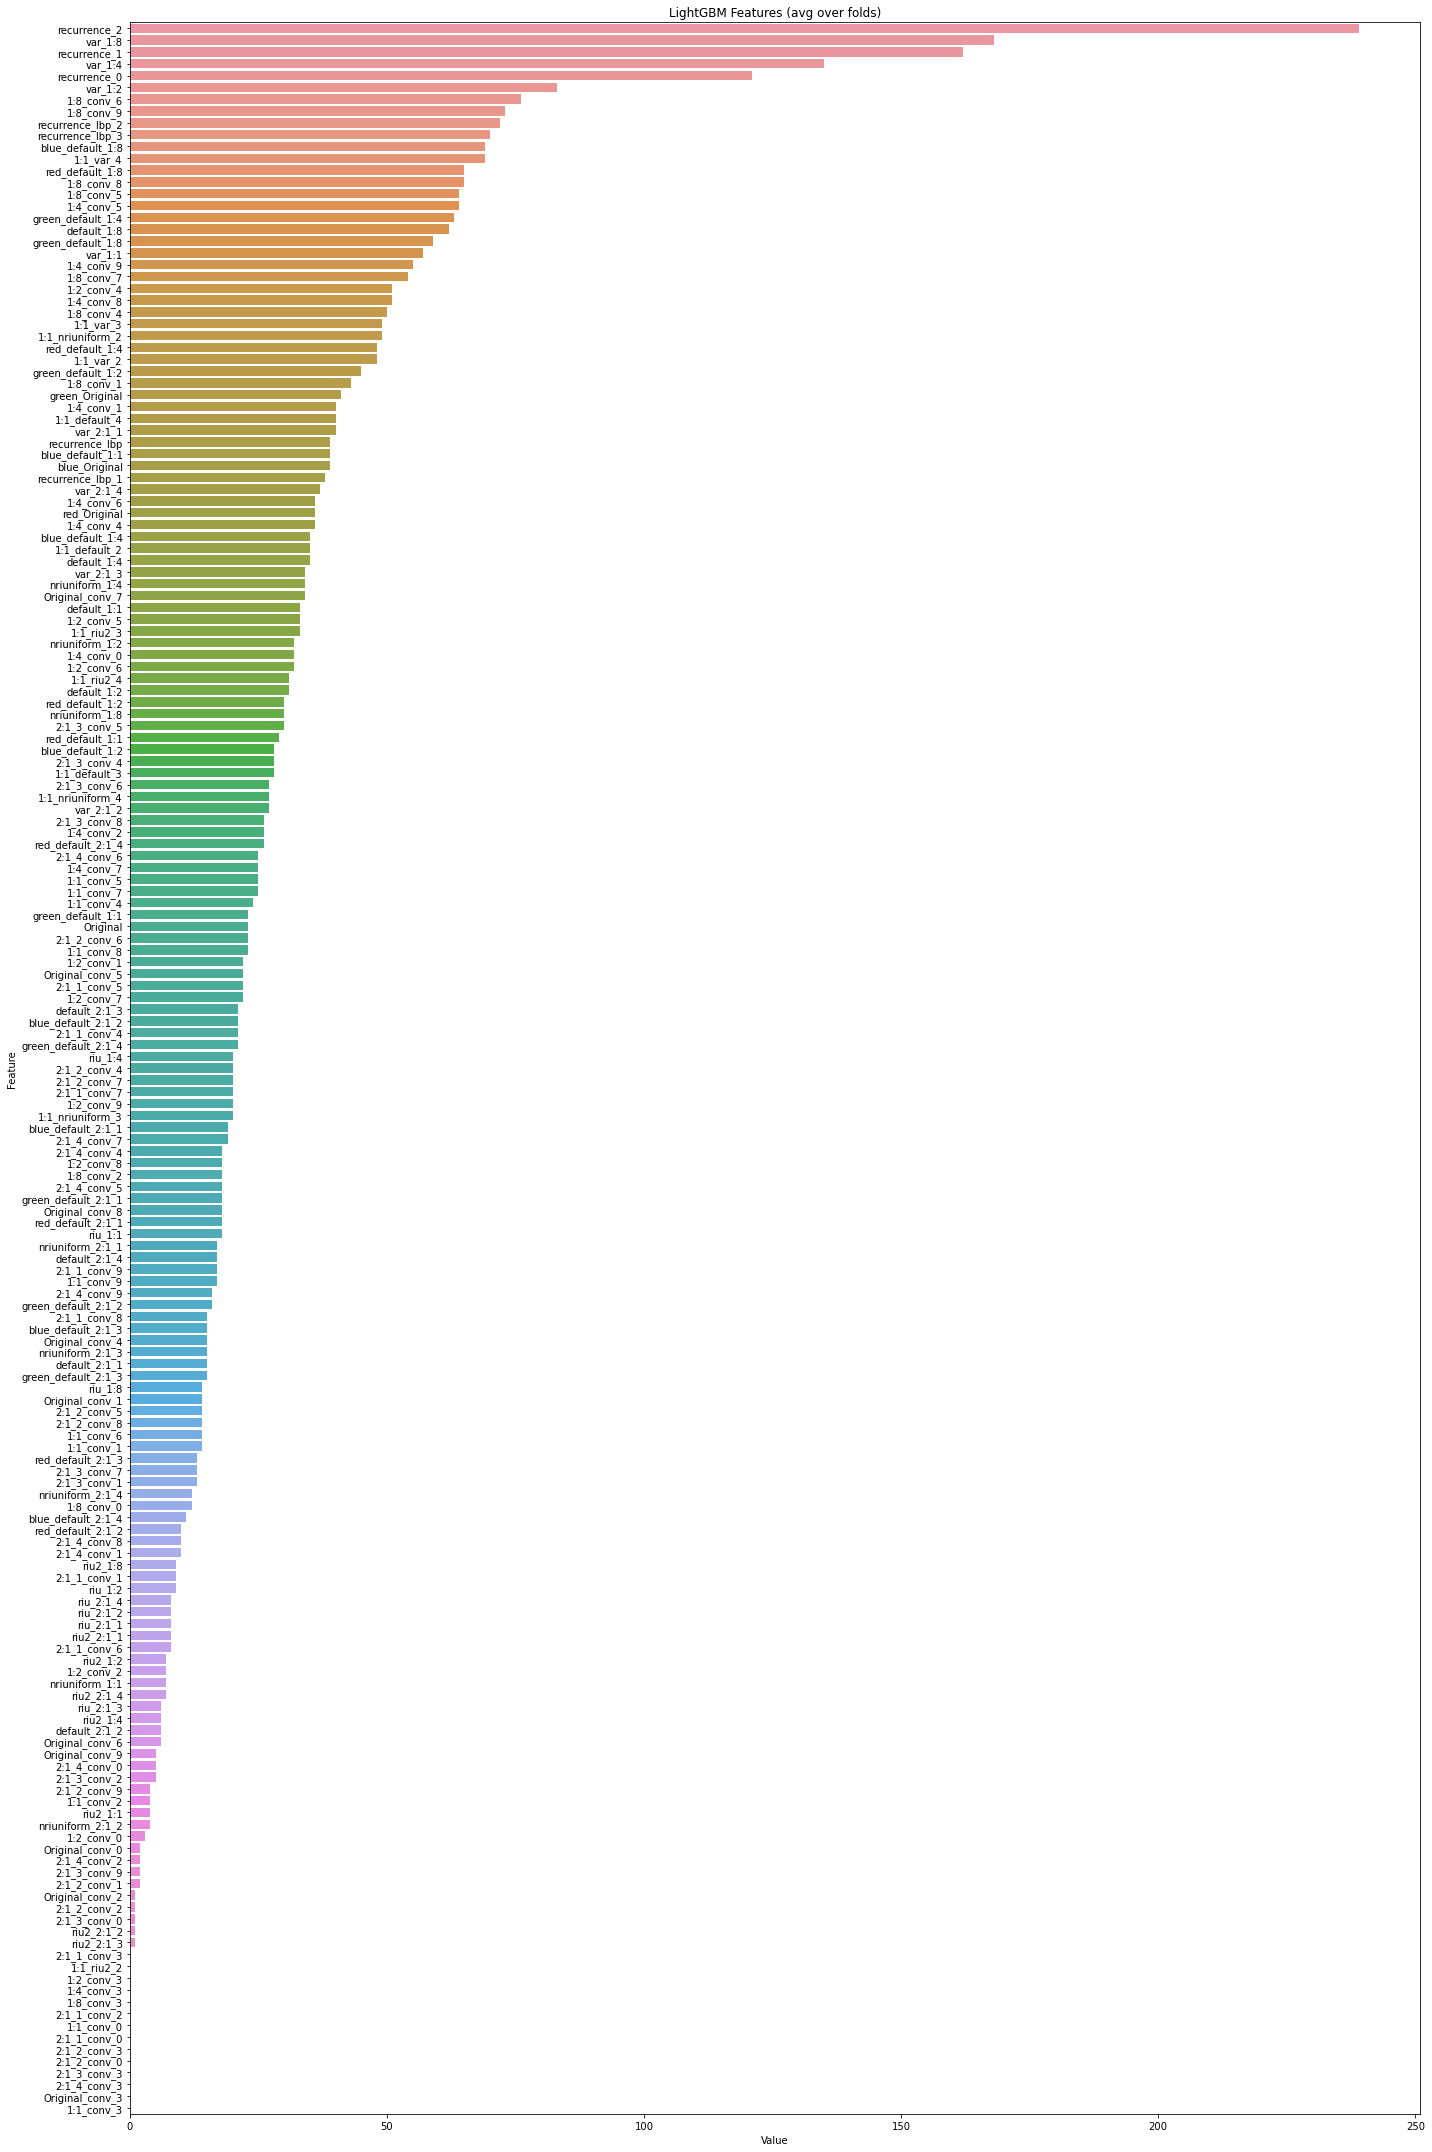

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [15]:
feature_imp['Feature_type'] = feature_imp['Feature']

for i, c in enumerate(feature_imp['Feature']):
    c_type = c
    if 'recurrence' in c:
        c_type = 'recurrence'
    elif 'conv' in c:
        c_type = 'conv'
    elif 'green' in c or 'blue' in c or 'red' in c:
        c_type = 'rgb'
    elif c.startswith('1:1_') and ('conv' not in c) and (c.endswith('_1') or c.endswith('_2') or c.endswith('_3') or c.endswith('_4')):
        c_type = 'radius'
    else:
        c_type = 'pyramid'
    feature_imp.loc[i, 'Feature_type'] = c_type

set(feature_imp['Feature_type'])

{'conv', 'pyramid', 'radius', 'recurrence', 'rgb'}

In [ ]:
feature_imp

In [ ]:
feature_imp.groupby("Feature_type")["Value"].sum().to_frame().sort_values(by="Value", ascending=False)

In [ ]:
feature_imp.groupby("Feature_type")["Value"].describe()